In [1]:
#@title Mount google drive and git pull
# this cell is to load the google drive to the directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Hpython/noise2pattern
!git pull

# Trying to train auto encoder to prove z is not robust to noise

Mounted at /content/drive
/content/drive/My Drive/Hpython/noise2pattern
Already up to date.


In [ ]:
#@title Loading data and NN
import torch
nn = torch.nn
import torch.utils.data as Data
import matplotlib.pyplot as plt


tr, lb = torch.load('../data/MNIST/processed/training.pt')
tr = tr.reshape(60000, 784).to(torch.float)
class LinearBlock(nn.Module):
    def __init__(self, in_channels,out_channels,activation=True):
        super(LinearBlock, self).__init__()
        if activation is True:
            self.block = nn.Sequential(
                nn.Linear(in_channels, out_channels),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                )
        else:
            self.block = nn.Sequential(
                nn.Linear(in_channels, out_channels),
                )
    def forward(self, x):
        return self.block(x)


class AE(nn.Module):
    """This is MLP version  -- ref VAESS
    Input shape [I,MNF], e.g.[32, 3*100*100]"""
    def __init__(self, dimx=784):
        super().__init__()

        self.dz = 32
        chans = (700, 600, 500, 400, 300)
        # chans = (2560, 2048, 1536, 1024, 512)
        self.encoder = nn.Sequential(
            LinearBlock(dimx, chans[0]),
            LinearBlock(chans[0],chans[1]),
            LinearBlock(chans[1],chans[2]),
            LinearBlock(chans[2],chans[3]),
            LinearBlock(chans[3],chans[4]),
            nn.Linear(chans[4], self.dz)
            )
        self.decoder = nn.Sequential(
            LinearBlock(self.dz, chans[4]),
            LinearBlock(chans[4],chans[3]),
            LinearBlock(chans[3],chans[2]),
            LinearBlock(chans[2],chans[1]),
            LinearBlock(chans[1],chans[0]),
            LinearBlock(chans[0],dimx,activation=False),
            )

    def forward(self, x):
        "Encoder and Get latent variable"
        zz = self.encoder(x)
        xhat = self.decoder(zz)

        return xhat, zz


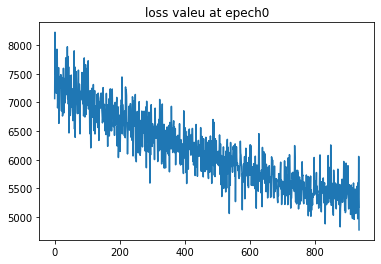

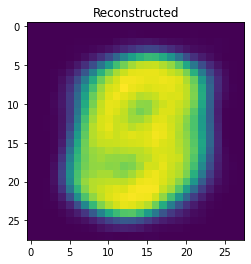

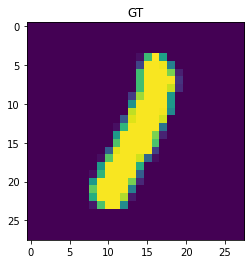

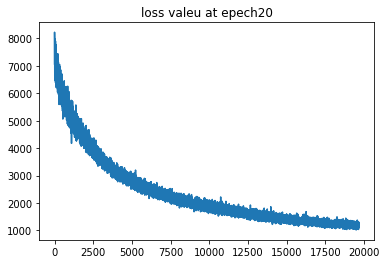

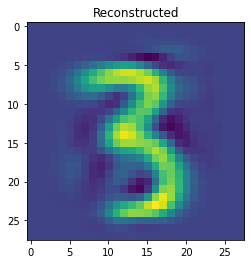

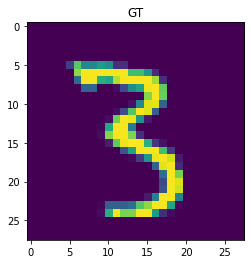

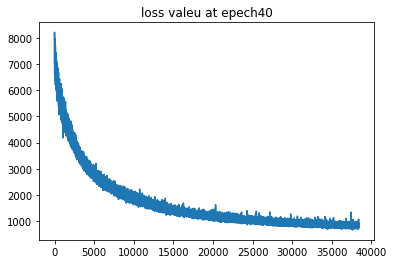

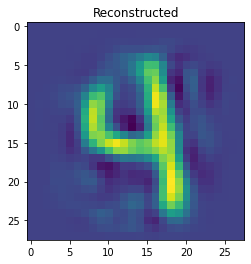

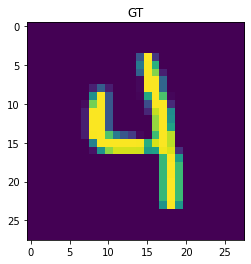

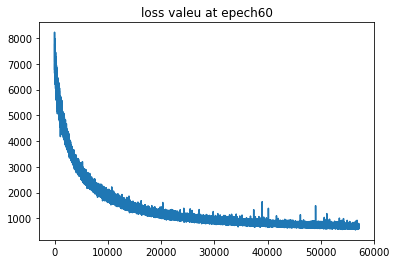

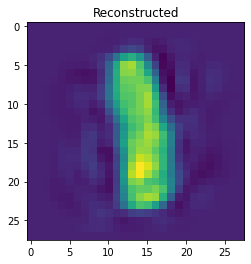

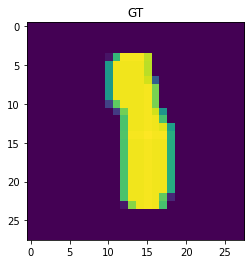

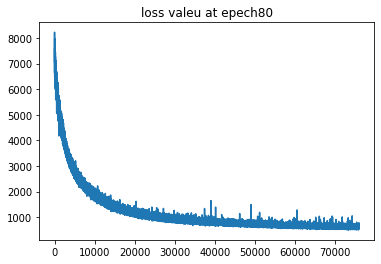

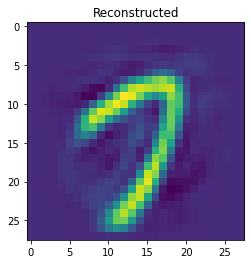

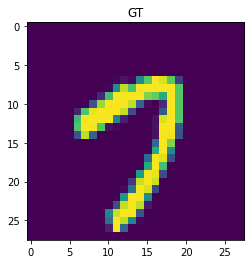

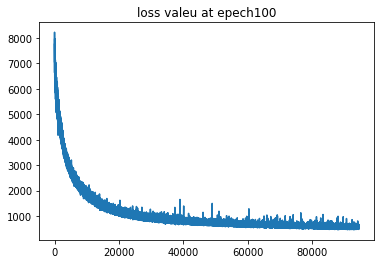

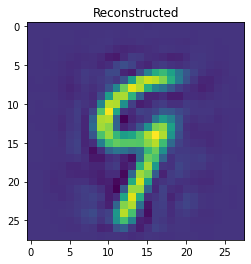

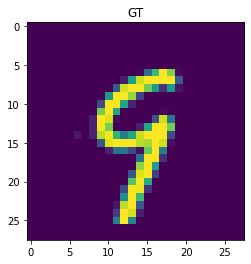

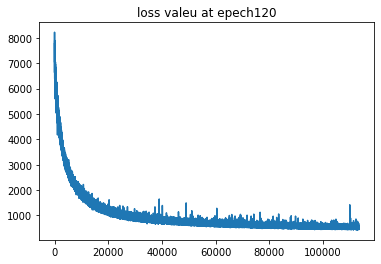

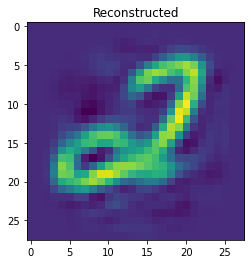

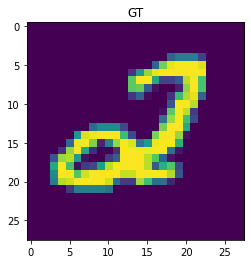

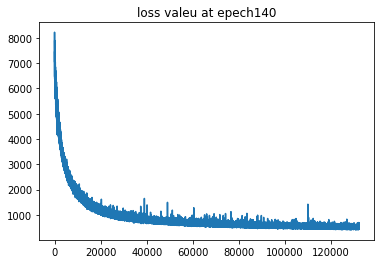

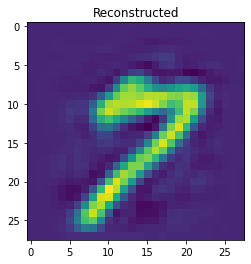

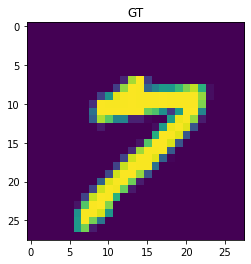

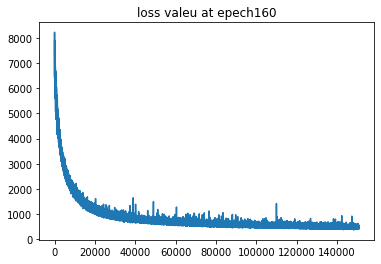

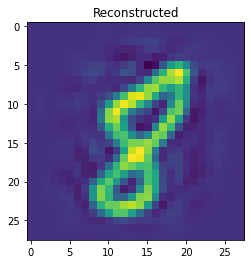

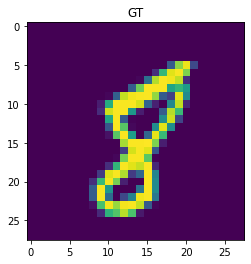

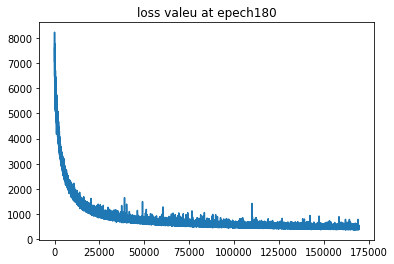

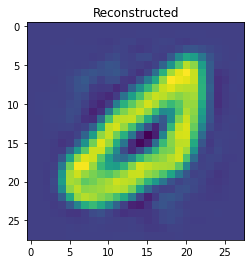

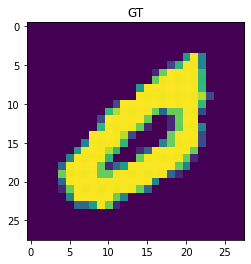

done


In [ ]:
#@title Train
data = Data.TensorDataset(tr)
dtr = Data.DataLoader(data, batch_size=64, shuffle=True, drop_last=True)
model = AE().cuda()
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                lr= 1e-4,
                betas=(0.9, 0.999), 
                eps=1e-8,
                weight_decay=0)
loss_track = []

for epoch in range(200):
    for i, (x,) in enumerate(dtr):
        optimizer.zero_grad() 
        x = x.cuda()
        xhat, z = model(x)
        loss = loss_fun(x, xhat)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        loss_track.append(loss.detach().cpu().item())

    if epoch%20 == 0:
        plt.figure()
        plt.plot(loss_track)
        plt.title(f'loss valeu at epech{epoch}')

        plt.figure()
        plt.imshow(xhat.detach().cpu()[0].reshape(28,28))
        plt.title('Reconstructed')

        plt.figure()
        plt.imshow(x.cpu()[0].reshape(28,28))
        plt.title('GT')
        plt.show()

        plt.close('all')
        torch.save(model, 'AE_model.pt')
print('done')

## test robust to nose or not

In [ ]:
#@title loading functions
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

def awgn(x, snr, seed=None):
    P = (x.norm()**2/x.numel()).item()
    gamma = 10 ** (snr / 10)
    # Generate noise samples
    noise = np.random.normal(0, (P/gamma/2)**0.5, x.shape[-1])
    # Noise up the original signal (again) and plot
    return x + torch.tensor(noise).to(x.device)

class LinearBlock(nn.Module):
    def __init__(self, in_channels,out_channels,activation=True):
        super(LinearBlock, self).__init__()
        if activation is True:
            self.block = nn.Sequential(
                nn.Linear(in_channels, out_channels),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(inplace=True),
                )
        else:
            self.block = nn.Sequential(
                nn.Linear(in_channels, out_channels),
                )
    def forward(self, x):
        return self.block(x)


class AE(nn.Module):
    """This is MLP version  -- ref VAESS
    Input shape [I,MNF], e.g.[32, 3*100*100]"""
    def __init__(self, dimx=784):
        super().__init__()

        self.dz = 32
        chans = (700, 600, 500, 400, 300)
        # chans = (2560, 2048, 1536, 1024, 512)
        self.encoder = nn.Sequential(
            LinearBlock(dimx, chans[0]),
            LinearBlock(chans[0],chans[1]),
            LinearBlock(chans[1],chans[2]),
            LinearBlock(chans[2],chans[3]),
            LinearBlock(chans[3],chans[4]),
            nn.Linear(chans[4], self.dz)
            )
        self.decoder = nn.Sequential(
            LinearBlock(self.dz, chans[4]),
            LinearBlock(chans[4],chans[3]),
            LinearBlock(chans[3],chans[2]),
            LinearBlock(chans[2],chans[1]),
            LinearBlock(chans[1],chans[0]),
            LinearBlock(chans[0],dimx,activation=False),
            )

    def forward(self, x):
        "Encoder and Get latent variable"
        zz = self.encoder(x)
        xhat = self.decoder(zz)

        return xhat, zz


class Decoder(nn.Module):
    """This is MLP version  -- ref VAESS
    Input shape [I,MNF], e.g.[32, 3*100*100]"""
    def __init__(self, dimx=784):
        super().__init__()

        self.dz = 32
        chans = (700, 600, 500, 400, 300)
        self.decoder = nn.Sequential(
            LinearBlock(self.dz, chans[4]),
            LinearBlock(chans[4],chans[3]),
            LinearBlock(chans[3],chans[2]),
            LinearBlock(chans[2],chans[1]),
            LinearBlock(chans[1],chans[0]),
            LinearBlock(chans[0],dimx,activation=False),
            )

    def forward(self, x):
        "Encoder and Get latent variable"
        xhat = self.decoder(x)

        return xhat

In [ ]:
with torch.no_grad():
    model = torch.load('AE_model.pt')
    decoder = Decoder().cuda()
    dict2 = decoder.state_dict()
    for k in model.state_dict().keys():
        if k in dict2.keys():
            dict2[k] = model.state_dict()[k]
    decoder.load_state_dict(dict2, strict=False)

tr, lb = torch.load('../data/MNIST/processed/test.pt')
tr = tr.reshape(10000, 784).to(torch.float)


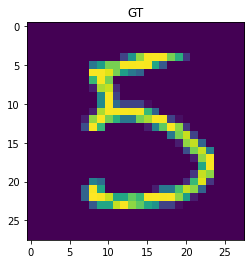

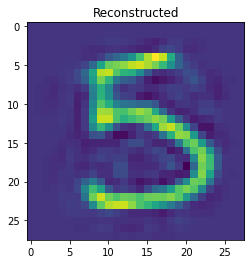

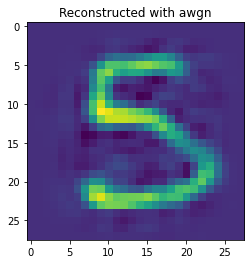

In [ ]:
model.eval()
decoder.eval()
sample_ind = 15
snr = 10
# with torch.no_grad():
#     xhat, z = model(tr[0].cuda().reshape(1,784))
#     xx = decoder(z)

# with torch.no_grad():
#     xhat, z = model(tr[0].cuda().reshape(1,784))
#     xx = decoder(awgn(z, snr=100).float().reshape(1,32))

with torch.no_grad():
    xhat, z = model(tr[sample_ind].cuda().reshape(1,784))
    xx = decoder(awgn(z, snr=snr).float().reshape(1,32))

plt.figure()
plt.imshow(tr[sample_ind].reshape(28,28))
plt.title('GT')


plt.figure()
plt.imshow(xhat.detach().cpu()[0].reshape(28,28))
plt.title('Reconstructed')

plt.figure()
plt.imshow(xx.detach().cpu()[0].reshape(28,28))
plt.title('Reconstructed with awgn')

plt.show()

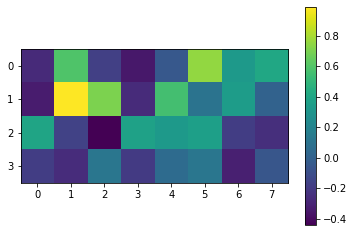

In [ ]:
plt.imshow(awgn(z.detach().cpu().reshape(4,8)))
plt.colorbar()

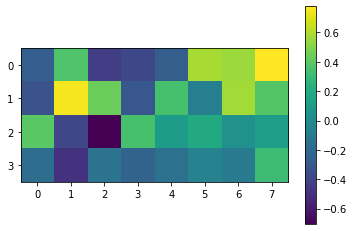

In [ ]:
plt.imshow(awgn(z.detach().cpu().reshape(4,8), snr=0))
plt.colorbar()